<a href="https://colab.research.google.com/github/vanderbilt-data-science/lo-achievement/blob/main/prompt_with_vector_store_w_grading_intr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLMs for Self-Study
> A prompt and code template for better understanding texts

This notebook provides a guide for using LLMs for self-study programmatically. A number of prompt templates are provided to assist with generating great assessments for self-study, and code is additionally provided for fast usage. This notebook is best leveraged for a set of documents (text or PDF preferred) **to be uploaded** for interaction with the model.

This version of the notebook is best suited for those who prefer to use files from their local drive as context rather than copy and pasting directly into the notebook to be used as context for the model. If you prefer to copy and paste text, you should direct yourself to the [prompt_with_context](https://colab.research.google.com/github/vanderbilt-data-science/lo-achievement/blob/main/prompt_with_context.ipynb) notebook.

In [1]:
#libraries for user setup code
from getpass import getpass
from logging import raiseExceptions

## Helper functions
The following functions help to encapsulate the functionality executed below. The `setup_drives` function below assists with setting up the drives for users to upload files.

In [2]:
def setup_drives(upload_set):

    upload_set = upload_set.lower()

    # Colab file upload module
    if upload_set == "local drive":
        from google.colab import files
        uploaded = files.upload()
    elif upload_set == "google drive":
        # Mount a Google Drive
        from google.colab import drive
        drive.mount('/content/drive')
    # Raise errors
    elif upload_set == '':
        raise ValueError("You haven't yet defined the upload_settings variable. Go back and read the instructions to make this setting.")
    else:
        raise SyntaxError("Please check your setting for typos and/or capitalization")

# User Settings
In this section, you'll set your OpenAI API Key (for use with the OpenAI model), configure your environment/files for upload, and upload those files.

In [3]:
# Run this cell and enter your OpenAI API key when prompted
openai_api_key = getpass()

In [4]:
# Model name
mdl_name = 'gpt-3.5-turbo-0301'

## Define Your Document Source
You may upload your files directly from your computer, or you may choose to do so via your Google Drive. Below, you will find instructions for both methods.

For either model, begin by setting the `upload_setting` variable to:
* `'Local Drive'` - if you have files that are on your own computer (locally), or
* `'Google Drive'` - if you have files that are stored on Google Drive

e.g.,
`upload_setting='Google Drive'`.
Don't forget the quotes around your selection!

In [5]:
## Settings for upload: via local drive or Google Drive
### Please input either "Google Drive" or "Local Drive" into the empty string

upload_setting = 'Local Drive'
#upload_setting = 'Google Drive'
#upload_setting = 'Local Drive'

<p style='color:green'><strong>Before Continuing</strong> - Make sure you have input your choice of upload into the `upload_setting`` variable above (Options: "Local Drive" or "Google Drive") as described in the above instructions.</p>

## Upload your Files
Now, you'll upload your files. When you run the below code cell, you'll be able to follow the instructions for local or Google Drive upload described here. If you would like to use our example document (Robert Frost's "The Road Not Taken", you can download the file from [this link](https://drive.google.com/drive/folders/1wpEoGACUqyNRYa4zBZeNkqcLJrGQbA53?usp=sharing) and upload via the instructions above.

**If you selected "Local Drive" :**
> If you selected Local Drive, you'll need to start by selecting your local files. Run the code cell below. Once the icon appears, click the "Choose File". This will direct you to your computer's local drive. Select the file you would like to upload as context. The files will appear in the right sidebar. Then follow the rest of the steps in the "Uploading Your files (Local Drive and Google Drive)" below.

**If you selected "Google Drive" :**
> If you selected Google Drive, you'll need to start by allowing access to your Google Drive. Run the code cell below. You will be redirected to a window where you will allow access to your Google Drive by logging into your Google Account. Your Drive will appear as a folder in the left side panel. Navigate through your Google Drive until you've found the file that you'd like to upload.

Your files are now accessible to the code.

In [6]:
# Run this cell then following the instructions to upload your file
setup_drives(upload_setting)

Saving roadnottaken.txt to roadnottaken.txt


## Setup file path
Now that you've make your files accessible, we need to select the files of interest. To do this, you'll use the Files pane on the left, following the instructions below to get the filepath. Then, you'll paste the filepath between the quotes below to define the `file_path` variable.

<center>
<table width="100%">
    <tr>
        <th width="35%"> Step 1. Navigate to the three dots to the right <br> of your file name and click them. </th>
        <th width="35%"> Step 2. Once the dropdown appears,<br>select "Copy Path." </th>
        <th width="30%"> Step 3. Paste the filepath between the single quotes<br> in the cell below to <br>define the file path. </th>
    </tr>
    <tr width="100%">
        <th width="35%"> 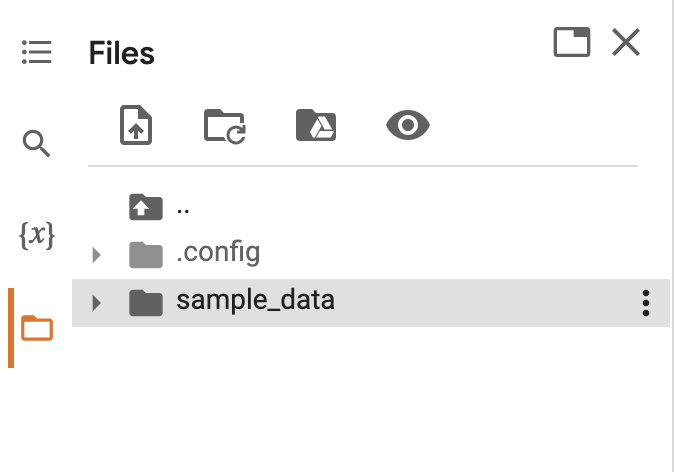 </th>
        <th> 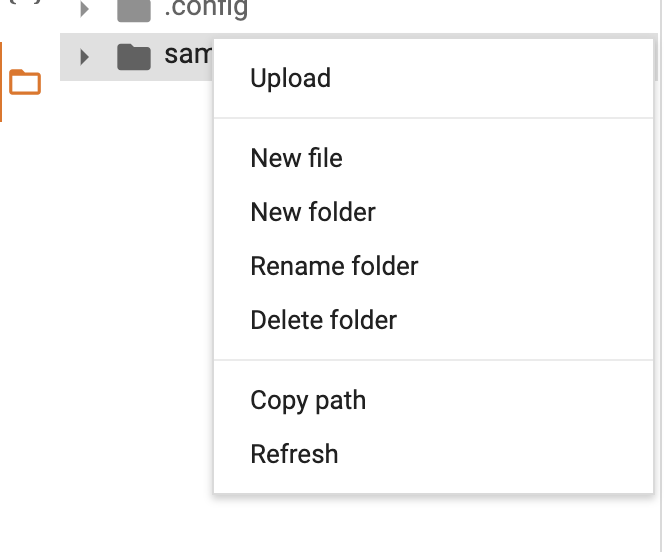 </th>
        <th width="23%"> Add your filepath to the cell which follows. <br>Example: <br><code>file_path = 'content/roadnottaken.txt'</code> </th>
    </tr>
</table>
</center>

In [7]:
## Paste your file path into the empty string('') below
#file_path = '/content/roadnottaken.txt' (example)

file_path = '/content/roadnottaken.txt'

Congratulations! You've finished with the setup! From here, you can now run the rest of the cells to set up your vector store and begin prompting!

# Code Setup
Run the following cells to setup the rest of the environment for prompting. In the following section, we set up the computational environment with imported code, setup your API key access to OpenAI, and loading access to your language model. Note that the following cells may take a long time to run.

## Library installation and loading
The following `pip install` code should be run if you're using Google Colab, or otherwise do not have a computational environment (e.g., _venv_, _conda virtual environment_, _Docker, Singularity, or other container_) with these packages installed.

In [9]:
# run this code if you're using Google Colab or don't have these packages installed in your computing environment
! pip install -q langchain=='0.0.229' openai gradio numpy chromadb tiktoken unstructured pdf2image pydantic=="1.10.8"

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.7/966.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 62.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 66.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [10]:
# import required libraries
# import required libraries
import numpy as np
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
import os
from langchain.vectorstores import Chroma
from langchain.document_loaders.unstructured import UnstructuredFileLoader
from langchain.document_loaders import UnstructuredFileLoader
from langchain.chains import VectorDBQA
from langchain.chat_models import ChatOpenAI
# from langchain.chains import RetrievalQA

## API and model setup

Use these cells to load the API keys required for this notebook and create a basic OpenAI LLM model. The code below uses the variable you created above when you input your API Key.

In [11]:
# Set up OpenAI API Key
os.environ["OPENAI_API_KEY"] = openai_api_key
llm = ChatOpenAI()

# Create a vector store with your document

With the file path, you can now create a vector store using the document that you uploaded. We expose this creation in case you want to modify the kind of vector store that you're creating. Run the cell below to create the default provided vector store.

In [12]:
# Create vector store

loader = UnstructuredFileLoader(file_path)
documents = loader.load()

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

embeddings = OpenAIEmbeddings()

db = Chroma.from_documents(texts, embeddings)

qa = VectorDBQA.from_chain_type(llm=ChatOpenAI(model_name = mdl_name), chain_type="stuff", vectorstore=db, k=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
/usr/local/lib/python3.10/dist-packages/langchain/chains/retrieval_qa/base.py:243: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


# A guide to prompting for self-study
In this section, we provide a number of different approaches for using AI to help you assess and explain the knowledge of your document. Start by interacting with the model and then try out the rest of the prompts!

## Interact with the model

Now that your vector store is created, you can begin interacting with the model! Below, we have a comprehensive list of examples using different question types, but feel free to use this code block to experiment with the model and the grading capabilities and interactivity component of the model.

First, input the number of desired questions as an integer (i.e., do not put parentheses around the number). See example below:



```
num_questions = 3
```



Then , input your desired question type into the empty string in the code cell. See example below:



```
question_type = 'Multiple Choice'
```

Finally, simply run the code block!


In [120]:
outputs = []

In [121]:
# Experiment with interacting with the model by inputting your own prompts into the empty string below.
input_message = 'How many questions would you like?' + '\n'
num_questions = int(input(input_message))
# Example: 3

input_message1 = 'What type of question would you like?' + '\n'
question_type = input(input_message1)
# Example: 'Multiple Choice'

query = 'Please design a ' + str(num_questions) + '-' + ' question quiz about the poem which reflects the learning objectives:' + '\n' + '1. Identify the key elements of the poem: narrator, setting, and underlying message.' + '\n' + '2. Understand the literary devices used in poetry and their purposes.' + '\n' + 'The questions should be ' + question_type + '. Do not provide the answers.' + '\n'

query_prefix = "The uploaded document should serve as the basis for the instructions that follow:" + "\n"

question = qa.run(query_prefix + query)

outputs = [('Model: ' + input_message), ('User: ' + str(num_questions)), '\n', ('Model: ' + input_message1) , ('User: ' + question_type), '\n', 'User: ', '\n', query_prefix + query, '\n', 'Model: ', '\n', question, '\n']


How many questions would you like?
3
What type of question would you like?
multiple choice


## Grading Interaction
If you would like the model to grade your responses, you can use the following code cells to do so.

Run the code cell to get a template for entering your answers and recieving feedback. Below is an example of what the template looks like.

```
answer_q1 = "Question 1 answer: Your Answer Here"
grade_q1 = question + prompt + answer_q1
feedback1 = qa.run(grade_q1)
feedback1
```

The after running the cell, the ouput will print below the cell. Copy the entirity of the output. In the blank cell below, you will paste the output.

The only change you will have to make to the template is your answer to the question. Input your answer over the "Your Answer Here" text. See the example below.

```
answer_q1 = "Question 1 answer: A"
```

In [122]:
# Run this cell to input your answers
print(question)
print()

for x in range(0, num_questions, 1):
  q_answer = 'What is your answer to question ' + str(x + 1) + "? " + '\n'
  answer = input(q_answer)
  globals()['answer%s' % x] = answer
  outputs.append('Model: ' + q_answer)
  outputs.append('User: ' + answer)


1. What is the underlying message of the poem "The Road Not Taken"?
A. Always choose the path less traveled.
B. It's important to make decisions quickly.
C. All paths lead to the same destination.

2. Who is the narrator of the poem?
A. Robert Frost
B. A traveler in a yellow wood
C. The undergrowth

3. Which literary device is used in the line "Two roads diverged in a yellow wood"?
A. Simile
B. Metaphor
C. Personification

What is your answer to question 1? 
A
What is your answer to question 2? 
A
What is your answer to question 3? 
A


In [123]:
# Grading cell - Run without making changes. Copy the output and paste into empty cell below.

prompt = "Please grade my quiz based on the question you produced and my answer. If I am correct, please answer 'You are correct.'. If I am incorrect, do not provide an explanation: you should simply respond 'You are incorrect. The right answer is (the right answer)'. Here is a template for a correct answer: 'You are correct.' Here is a template for an incorrect answer: 'You are incorrect, the correct answer is C.' Do not include any context from the question, and any of the answers."

def answer_template(num_questions):
  print('total_feedback = []')
  for x in range(0, num_questions, 1):
    print('answer_q' + str(x + 1) + ' = ' + '"Question ' + str(x + 1) +  ' answer:" ' + '+ ' + ('answer' + str(x)))
    print('grade_q' + str(x + 1) + ' = question + prompt + answer_q' + str(x + 1))
    print('feedback' + str(x + 1) + ' = qa.run(grade_q' + str(x + 1) + ')' )
    print('feedback' + str(x + 1))
    print('total_feedback.append(feedback' + str(x + 1) + ')')
    print()
  print('print(total_feedback)')

template = answer_template(num_questions)
template


total_feedback = []
answer_q1 = "Question 1 answer:" + answer0
grade_q1 = question + prompt + answer_q1
feedback1 = qa.run(grade_q1)
feedback1
total_feedback.append(feedback1)

answer_q2 = "Question 2 answer:" + answer1
grade_q2 = question + prompt + answer_q2
feedback2 = qa.run(grade_q2)
feedback2
total_feedback.append(feedback2)

answer_q3 = "Question 3 answer:" + answer2
grade_q3 = question + prompt + answer_q3
feedback3 = qa.run(grade_q3)
feedback3
total_feedback.append(feedback3)

print(total_feedback)


In [124]:
# Copy the output here

total_feedback = []
answer_q1 = "Question 1 answer:" + answer0
grade_q1 = question + prompt + answer_q1
feedback1 = qa.run(grade_q1)
feedback1
total_feedback.append(feedback1)

answer_q2 = "Question 2 answer:" + answer1
grade_q2 = question + prompt + answer_q2
feedback2 = qa.run(grade_q2)
feedback2
total_feedback.append(feedback2)

answer_q3 = "Question 3 answer:" + answer2
grade_q3 = question + prompt + answer_q3
feedback3 = qa.run(grade_q3)
feedback3
total_feedback.append(feedback3)

answers_total = []
x = 1
for i in total_feedback:
  answer_print = (str(x) +  ". " + i)
  print(answer_print)
  answers_total.append(answer_print)
  x = x + 1

for i in answers_total:
  outputs.append('Model: ' + i)

1. You are incorrect, the correct answer is C.
2. You are correct.
3. You are incorrect, the correct answer is B.


### Recieve your grade!

Run the following cell to recieve your grade in a percentage form.

In [125]:
import math

def points_add(feedback):
  points = []
  for answer in feedback:
    if answer == "You are correct.":
      points = points + [1]
    else:
      points = points
  return points

points_list = points_add(total_feedback)

def sum_points(points):
  sum_total = sum(points)
  return sum_total

total = sum_points(points_list)

def grade_percent(total, num_questions):
  percent = (total / num_questions) * 100
  return percent

percent = grade_percent(total, num_questions)

if percent > 80:
  more_than_80 = 'Nice job! Your score was ' + str(round(percent)) + '%'
  print(more_than_80)
  outputs.append('Model: ' + more_than_80)
elif percent < 80 and percent > 60:
  more_than_60 = "You're getting there! Your score was " + str(round(percent)) + '%'
  print(more_than_60)
  outputs.append('Model: ' + more_than_60)
else:
  less_than_60 = 'Keep studying! Your score was ' + str(round(percent)) + '%'
  print(less_than_60)
  outputs.append('Model: ' + less_than_60)



Keep studying! Your score was 33%


# Keep chatting with the model!

Below are some examples of ways you can continue to interact with the model and recieve more feedback!


### Ask about a specific question

First, input the question you would like further elaboration on (input the question number).

Next, input your prompt. What part of the question would you like further explanation on? Below is an example prompt.



```
Can you please explain elaborate on the correct answer for question 1?
```

The prompt can be as broad or as specific as you would like. However, more specific questions will likely yield a better response from the model!

### Follow-up

You can also ask a follow-up question if you are still struggling to understand specific parts of the question. Another input box will appear. If you would like to ask further questions, type "Yes." Another input box will appear where you can ask further questions. If you type "No", the interaction with the model will cease.

In [126]:
which_question = 'Input the question number you would like feedback on here! ' + '\n'
question_number = int(input(which_question))
# Example = 1
outputs.append('Model: ' + which_question)
outputs.append('User: ' + str(question_number))

def feedback_assign(question_number, feedback_list):
  for i in total_feedback:
    if feedback_list.index(i) == (question_number - 1) :
      feedback = 'feedback' + 'question_number + 1'
    else:
      pass
  return feedback

query_input = 'How can I help you better understand the answer to this question? ' + '\n'
outputs.append('Model: ' + query_input)
query = input(query_input)
# Example: 'Can you please explain elaborate on the correct answer for question 1?'
outputs.append('User: ' + query)

response = qa.run(question + feedback_assign(question_number, total_feedback) + query)
print(response)
outputs.append('Model: ' + response)

any_followup = 'Would you like to ask any follow-up questions about my response?' + '\n'
outputs.append('Model: ' + any_followup)
more_questions = input(any_followup)
outputs.append('User: ' + more_questions)
if more_questions == "No":
    no = 'Great! I am happy that I could assist you in your learning.'
    outputs.append('Model: ' + no)
    print(no)
while more_questions == 'Yes':
    outputs.append('User: ' + more_questions)
    query2_input = "What further questions do you have about question " + str(question_number) + '?' + '\n'
    outputs.append('Model: ' + query2_input)
    second_query = input()
    response1 = qa.run(question + feedback_assign(question_number, total_feedback) + response + second_query)
    outputs.append('User: ' + second_query)
    outputs.append('Model: ' + response1)
    print(response1)
    more_questions = input('Would you like to ask any follow-up questions about my response?' + '\n')
    if more_questions == "No":
      no1 = 'Great! I am happy that I could assist you in your learning.'
      outputs.append('Model: ' + more_questions)
      outputs.append('User: ' + no1)
      print(no1)
      break

Input the question number you would like feedback on here! 
1
How can I help you better understand the answer to this question? 
Why was my answer to question 1 incorrect?
I'm sorry, there seems to be an error. I did not provide an answer to your questions yet. Please provide the questions again.
Would you like to ask any follow-up questions about my response?
No
Great! I am happy that I could assist you in your learning.


### Ask further questions about the context

You can also ask the model more follow-up questions about the context, unrelated to the questions it produced or your answers. Simpl input

In [127]:
input_message2 = 'What else can I assist you with? If you have no further questions, please answer "Nothing".' + '\n'
outputs.append('Model: ' + input_message2)
query = input(input_message2)
outputs.append('User: ' + query)

if query == "Nothing":
  nothing = "Great! I am happy I could assist you in your learning"
  print(nothing)
  outputs.append('Model: ' + nothing)
else:
  follow_up = qa.run(query)
  outputs.append('Model: ' + follow_up)
  print(follow_up)
  more_assist = 'Is there anything else I can assist you with? Please answer "Yes" or "No".' + '\n'
  more_follow_up = input(more_assist)
  while more_follow_up == 'Yes':
    outputs.append("User: " + more_follow_up)
    more_further = "What further questions do you have?" + '\n'
    query = input(more_further)
    outputs.append('Model: ' + more_further)
    outputs.append("User: " + query)
    follow_up = qa.run(query)
    outputs.append('Model: ' + follow_up)
    print(follow_up)
    more_questions_again = 'Would you like to ask any follow-up questions about my response? Please answer "Yes" or "No".' + '\n'
    more_questions = input(more_questions_again)
    outputs.append("Model: " + more_questions_again)
    outputs.append("User: " + more_questions)
    if more_questions == "No":
      no_more = 'Great! I am happy that I could assist you in your learning.'
      print(no_more)
      outputs.append("Model: " + no_more)
      break

What else can I assist you with? If you have no further questions, please answer "Nothing".
What is the importance of metaphors in poetry?
Metaphors are a powerful tool in poetry as they help to create images and comparisons that allow readers to understand and feel emotions that are not directly stated. By comparing two seemingly unrelated things, poets can create a deeper understanding of the subject matter and allow readers to connect with the poem on a more personal level. Overall, metaphors bring depth and richness to poetry, making it a more enjoyable and meaningful experience for readers.
Is there anything else I can assist you with? Please answer "Yes" or "No".
No


In [128]:
for i in outputs:
  print(i)

Model: How many questions would you like?

User: 3


Model: What type of question would you like?

User: multiple choice


User: 


The uploaded document should serve as the basis for the instructions that follow:
Please design a 3- question quiz about the poem which reflects the learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
The questions should be multiple choice. Do not provide the answers.



Model: 


1. What is the underlying message of the poem "The Road Not Taken"?
A. Always choose the path less traveled.
B. It's important to make decisions quickly.
C. All paths lead to the same destination.

2. Who is the narrator of the poem?
A. Robert Frost
B. A traveler in a yellow wood
C. The undergrowth

3. Which literary device is used in the line "Two roads diverged in a yellow wood"?
A. Simile
B. Metaphor
C. Personification


Model: What is your answer to que

In [131]:
# convert to json
import json
from google.colab import files

def save_chat_dialogue(outputs, filename='chat_dialogue.json'):
  with open(filename, 'w') as file:
    json.dump(outputs, file)
  files.download(filename)

save_chat_dialogue(outputs)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Prompt Examples**

## Types of Questions and Prompts

Below is a comprehensive list of question types and prompt templates designed by our team. There are also example code blocks, where you can see how the model performed with the example and try it for yourself using the prompt template.

### Multiple Choice

Prompt: The following text should be used as the basis for the instructions which follow: {context}. Please design a 5 question quiz about {name or reference to context} which reflects the learning objectives: {list of learning objectives}. The questions should be multiple choice. If I get an answer wrong, provide me with an explanation of why it was incorrect, and then give me additional chances to respond until I get the correct choice. Explain why the correct choice is right.

In [ ]:
# Multiple choice code example
query = """Please design a 5 question quiz about Robert Frost's "Road Not Taken" which reflects the learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes. The questions should be multiple choice.
If I get an answer wrong, provide me with an explanation of why it was incorrect, and then give me additional
chances to respond until I get the correct choice. Explain why the correct choice is right. """

query_prefix = "The uploaded document should serve as the basis for the instructions that follow:"
answer = qa.run(query_prefix + query)
print(answer)

### Short Answer

Prompt: Please design a 5-question quiz about {context} which reflects the learning objectives: {list of learning objectives}. The questions should be short answer. Expect the correct answers to be {anticipated length} long. If I get any part of the answer wrong, provide me with an explanation of why it was incorrect, and then give me additional chances to respond until I get the correct choice.

In [ ]:
# Short answer code example
query = """ Please design a 5-question quiz about Robert Frost's
"Road Not Taken" which reflects the learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
The questions should be short answer. Expect the correct answers to be
1-2 sentences long. If I get any part of the answer wrong,
provide me with an explanation of why it was incorrect,
and then give me additional chances to respond until I get the correct choice. """

answer = qa.run(query_prefix + query)
print(answer)

### Fill-in-the-blank

Prompt: Create a 5 question fill in the blank quiz refrencing {context}. The quiz should reflect the learning objectives: {learning objectives}. Please prompt me one question at a time and proceed when I answer correctly. If I answer incorrectly, please explain why my answer is incorrect.

In [ ]:
# Fill in the blank code example
query = """ Create a 5 question fill in the blank quiz refrencing Robert Frost's "The Road Not Taken."
The quiz should reflect the learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
Please prompt me one question at a time and proceed when I answer correctly.
If I answer incorrectly, please explain why my answer is incorrect. """

answer = qa.run(query_prefix + query)
print(answer)

### Sequencing

Prompt: Please develop a 5 question questionnaire that will ask me to recall the steps involved in the following learning objectives in regard to {context}: {learning objectives}. After I respond, explain their sequence to me.

In [ ]:
# Sequence example
query = """ Please develop a 5 question questionnaire that will ask me to recall the steps involved in the following learning objectives in regard to Robert Frost's "The Road Not Taken":
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
After I respond, explain their sequence to me."""

answer = qa.run(query_prefix + query)
print(answer)

### Relationships/drawing connections

Prompt: Please design a 5 question quiz that asks me to explain the relationships that exist within the following learning objectives, referencing {context}: {learning objectives}.

In [ ]:
# Relationships example
query = """ Please design a 5 question quiz that asks me to explain the relationships that exist within the following learning objectives, referencing Robert Frost's "The Road Not Taken":
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes."""

answer = qa.run(query_prefix + query)
print(answer)

### Concepts and Definitions

Prompt: Design a 5 question quiz that asks me about definitions related to the following learning objectives: {learning objectives} - based on {context}".
Once I write out my response, provide me with your own response, highlighting why my answer is correct or incorrect.

In [ ]:
# Concepts and definitions example
query = """ Design a 5 question quiz that asks me about definitions related to the following learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message, and
2. Understand the literary devices used in poetry and their purposes - based on Robert Frost's "The Road Not Taken".
Once I write out my response, provide me with your own response, highlighting why my answer is correct or incorrect."""

answer = qa.run(query_prefix + query)
print(answer)

### Real Word Examples

Prompt: Demonstrate how {context} can be applied to solve a real-world problem related to the following learning objectives: {learning objectives}. Ask me questions regarding this theory/concept.

In [ ]:
# Real word example
query = """ Demonstrate how Robert Frost’s “The Road Not Taken” can be applied to solve a real-world problem related to the following learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
Ask me questions regarding this theory/concept."""

answer = qa.run(query_prefix + query)
print(answer)

### Randomized Question Types

Prompt: Please generate a high-quality assessment consisting of 5 varying questions, each of different types (open-ended, multiple choice, etc.), to determine if I achieved the following learning objectives in regards to {context}: {learning objectives}. If I answer incorrectly for any of the questions, please explain why my answer is incorrect.

In [ ]:
# Randomized question types
query = """ Please generate a high-quality assessment consisting of 5 varying questions,
each of different types (open-ended, multiple choice, etc.),
to determine if I achieved the following learning objectives in regards to Robert Frost’s “The Road not Taken":
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes. If I answer incorrectly for any of the questions,
please explain why my answer is incorrect."""

answer = qa.run(query_prefix + query)
print(answer)


### Quantiative evaluation the correctness of a student's answer

Prompt: (A continuation of the previous chat) Please generate the main points of the student’s answer to the previous question, and evaluate on a scale of 1 to 5 how comprehensive the student’s answer was in relation to the learning objectives, and explain why he or she received this rating, including what was missed in his or her answer if the student’s answer wasn’t complete.


In [ ]:
# qualitative evaluation
qualitative_query = """ Please generate the main points of the student’s answer to the previous question,
 and evaluate on a scale of 1 to 5 how comprehensive the student’s answer was in relation to the learning objectives,
 and explain why he or she received this rating, including what was missed in his or her answer if the student’s answer wasn’t complete."""

# Note that this uses the previous result and query in the context
answer = qa.run(query_prefix + query)
print(answer)